# PC lab 6: Linear model selection - Regularization

We have already seen linear regression to tackle regression problems. With linear regression, we model a continous outcome as a linear function of the features:

\begin{equation}
\hat{y} = w_{0}x_{0} + w_{1}x_{1} + ... + w_{p}x_{p} = \sum\limits_{i=0}^{p}w_{i}x_{i}
\end{equation}

This works well when there are a lot of training observations and when the number of features (the dimensionality of the problem) is not too large. However, there are a couple of situations where ordinary linear regression might give problems:

* When the number of features $p$ becomes large with respect to the number of observations $n$, the variance of the model weights estimated by linear regression increases, which might result in poor predictive performance. Futhermore, there is no longer an analytical solution provided by least squares when $p > n$. 
* It is possible that there are a lot of uninteresting or redundant features. If we want a sparse and interpretable model, we might want to do feature selection to reduce $p$. 

In this lab, we will cover two solutions to the problems above: subset selection and regularization methods.

## Subset selection methods

In subset selection, we only use a subset of the features that are available. The goal is to come up with a model that is sparse and that generalizes better to unseen data. There are two main strategies for subset selection: in *best subset selection*, we fit all the $p \choose k$ models for each $k = 1, 2.. p$ and retain the best model for each $k$. Finally, we select the model that performs best on some measure that controls for overfitting: 

![bestsubset](img/best_subset.png)

This becomes quickly unfeasible for large values of $p$. Therefore, an alternative approach is to perform *stepwise selection*, which explores a much smaller set of feature combinations. Stepwise selection can be performed either backward or forward. For large $p$ they are the only computationally feasible subset selection methods. 

![forward](img/forward.png)

Finally, it is important to account for the fact that the MSE (or, equivalently, the RSS) will always go down on the training data as we add more and more features. To select the best model out of several candidates, it is important to have an estimate of the test error of each model. This can be done indirectly by using a metric that penalizes for model complexity such as the AIC or the adjusted $R^2$. Another option is to use cross-validation to get an estimate of the test error.

**Let's apply subset selection on two datasets.** The first dataset contains features of mixtures used to produce concrete. The goal is to predict the compressive strength of the concrete.

In [1]:
# Read in the data
import pandas as pd 

concretedata = pd.read_table('concreteComprStrength.txt', delim_whitespace=True, header=0, index_col=None)
concretedata.head()

,cement,blastFurnaceSlag,flyAsh,water,superelastizer,coarseAggregate,fineAggregate,age,compressiveStrength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


Run the code below to perform best subset selection with linear regression. The code implements algorithm 6.1 from the book as shown above. For each number of features $k$, the code will print the number of feature combinations that is explored. We fit a model for each combination, so there is quite some computation involved.

Number of combinations  with 1 features: 8.0
Number of combinations  with 2 features: 28.0
Number of combinations  with 3 features: 56.0
Number of combinations  with 4 features: 70.0
Number of combinations  with 5 features: 56.0
Number of combinations  with 6 features: 28.0
Number of combinations  with 7 features: 8.0
Number of combinations  with 8 features: 1.0
Best CV score using 1 features: 0.23563758467849444
Best CV score using 2 features: 0.33939124792705494
Best CV score using 3 features: 0.47496677416110905
Best CV score using 4 features: 0.5470110786366836
Best CV score using 5 features: 0.6013731980348769
Best CV score using 6 features: 0.6006439599344702
Best CV score using 7 features: 0.6036983111769251
Best CV score using 8 features: 0.6102540773255545
Best feature combination: ('cement', 'blastFurnaceSlag', 'flyAsh', 'water', 'superelastizer', 'coarseAggregate', 'fineAggregate', 'age')


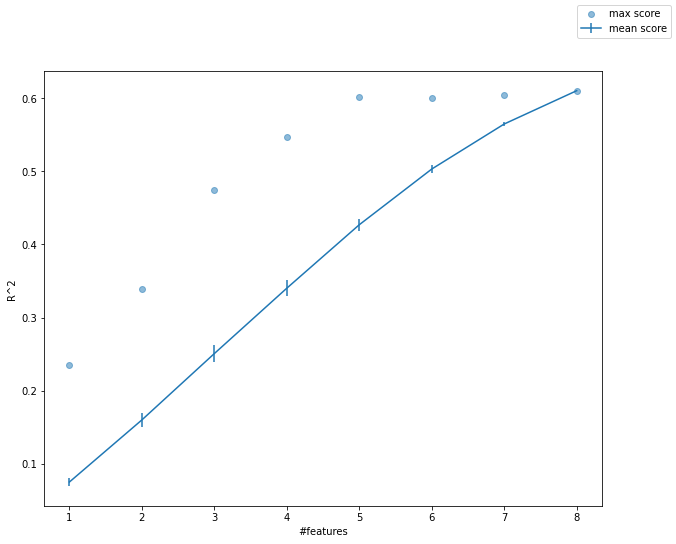

In [2]:
import scipy as scipy
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_validate
from itertools import combinations 
from matplotlib import pyplot as plt
%matplotlib inline

# Specify features and labels
X = concretedata.drop(['compressiveStrength'], axis=1)
y = concretedata['compressiveStrength']

# Dicts to store the feature combinations and their scores
scores_perNfeat = {'mean':[], 'max':[], 'var':[]}
best_feature_perNfeat = []
# Define splitter object outside loop to ensure same splits over loop
splitter = KFold(n_splits=5, shuffle=True, random_state=None)

# For k in 1,...,p
for k in np.arange(1,X.shape[1]+1):
    print('Number of combinations  with {} features: {}'.format(k, scipy.special.comb(X.shape[1],k)))
    best_score_k = 0
    scores_k_comb = []
    # Create and loop over all the possible feature combinations given k
    for c in combinations(X.columns, k):
        # Select features from data
        X_c = X[list(c)]
        # Define model
        model = LinearRegression()
        # Fit model and compute score on training data
        scores = cross_validate(model, X_c.values, y.values, cv=splitter)
        mean_cv_score = np.mean(scores['test_score'])
        # Save scores
        scores_k_comb.append(mean_cv_score)
        if mean_cv_score > best_score_k:
            best_features = c
            best_score_k = mean_cv_score
    # Save scores based on # features

    scores_perNfeat['max'].append(np.max(scores_k_comb))
    scores_perNfeat['var'].append(np.var(scores_k_comb))
    scores_perNfeat['mean'].append(np.mean(scores_k_comb))
    # Save best feature combination
    best_feature_perNfeat.append(best_features)

#Get variance of scores within grouped scores 
for i, score in enumerate(scores_perNfeat['max']):
    print("Best CV score using {} features: {}".format(i+1, score))

fig, ax = plt.subplots(1,1,figsize=(10,8), sharey=True)

ax.errorbar(np.arange(len(scores_perNfeat['mean']))+1, scores_perNfeat['mean'], scores_perNfeat['var'], label='mean score')
ax.scatter(np.arange(len(scores_perNfeat['max']))+1, scores_perNfeat['max'], alpha=0.5, label='max score')
ax.set_xlabel('#features')
ax.set_ylabel('R^2')
fig.legend()
print('Best feature combination: {}'.format(best_feature_perNfeat[np.argmax(scores_perNfeat['max'])]))

We will do the same thing for a second dataset. This time, the features are measurements from a flow cytometry experiment. The 'SC' features measure scatter, and say something about the morphologhy of the cells (FSC: forwad scatter, SSC: sideway scatter). The 'FL' features are fluorescence features from different parts of the spectrum. There are two possible bacterial species present in the dataset. The goal is to classify the correct species based on the measurements from the flow cytometer. Species number one corresponds to *Pseudomonas putida*, while species number 6 is *Brachybacterium faecium*. We will use logistic regression to do the classification.

In [10]:
# Read in the data
bacterialdata = pd.read_csv('fc_data_new.csv', index_col=0)
bacterialdata = bacterialdata.drop(['Width', 'Time'], axis=1).reset_index(drop=True)

In [11]:
bacterialdata.head()

,FSC-A,SSC-A,FL1-A,FL2-A,FL3-A,FL4-A,FSC-H,SSC-H,FL1-H,FL2-H,species
0,47325.0,11730.0,311772.0,70873.0,70379.0,0.0,55410.0,13649.0,208324.0,47062.0,6
1,15766.0,4417.0,285761.0,64624.0,50408.0,0.0,36950.0,8129.0,238931.0,52847.0,6
2,11206.0,3194.0,403584.0,96978.0,73632.0,18.0,33761.0,4810.0,358999.0,86278.0,6
3,33577.0,5558.0,258064.0,52010.0,35322.0,0.0,72014.0,10396.0,226185.0,44847.0,1
4,5525.0,2417.0,348457.0,64062.0,33637.0,1525.0,19074.0,5938.0,304335.0,55864.0,6


Number of combinations  with 1 features: 10.0
Number of combinations  with 2 features: 45.0
Number of combinations  with 3 features: 120.0
Number of combinations  with 4 features: 210.0
Number of combinations  with 5 features: 252.0
Number of combinations  with 6 features: 210.0
Number of combinations  with 7 features: 120.0
Number of combinations  with 8 features: 45.0
Number of combinations  with 9 features: 10.0
Number of combinations  with 10 features: 1.0
Best CV score using 1 features: 0.60925
Best CV score using 2 features: 0.7975
Best CV score using 3 features: 0.8022500000000001
Best CV score using 4 features: 0.8000000000000002
Best CV score using 5 features: 0.80325
Best CV score using 6 features: 0.7902500000000001
Best CV score using 7 features: 0.7875
Best CV score using 8 features: 0.7855000000000001
Best CV score using 9 features: 0.78
Best CV score using 10 features: 0.77975
Best feature combination: ('SSC-A', 'FL2-A', 'FL3-A', 'SSC-H', 'FL1-H')


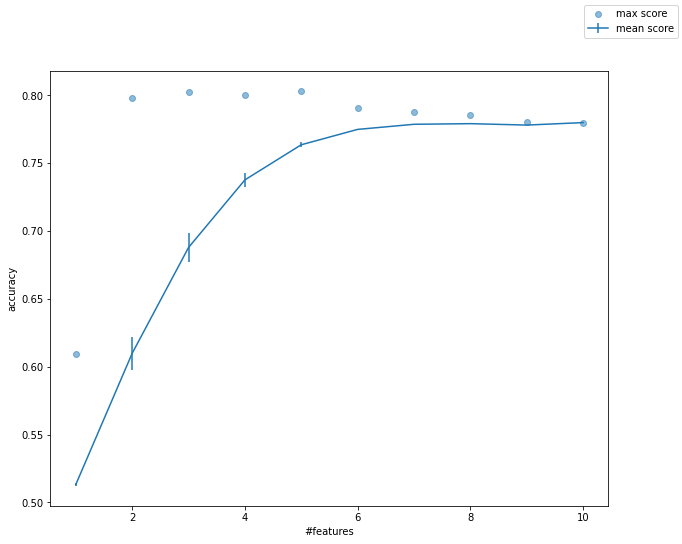

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# Specify features and labels
X = bacterialdata.drop(['species'], axis=1)
y = bacterialdata['species']

# Dicts to store the feature combinations and their scores
scores_perNfeat = {'mean':[], 'max':[], 'var':[]}
best_feature_perNfeat = []
# Define splitter object outside loop to ensure same splits over loop
splitter = KFold(n_splits=5, shuffle=True, random_state=None)

# For k in 1,...,p
for k in np.arange(1,X.shape[1]+1):
    print('Number of combinations  with {} features: {}'.format(k, scipy.special.comb(X.shape[1],k)))
    best_score_k = 0
    scores_k_comb = []
    # Create and loop over all the possible feature combinations given k
    for c in combinations(X.columns, k):
        # Select features from data
        X_c = X[list(c)]
        # Define model
        model = LogisticRegression() # or model = LDA()
        # Fit model and compute score on training data
        scores = cross_validate(model, X_c.values, y.values, cv=splitter, n_jobs=4)
        mean_cv_score = np.mean(scores['test_score'])
        # Save scores
        scores_k_comb.append(mean_cv_score)
        if mean_cv_score > best_score_k:
            best_features = c
            best_score_k = mean_cv_score
    # Save scores based on # features

    scores_perNfeat['max'].append(np.max(scores_k_comb))
    scores_perNfeat['var'].append(np.var(scores_k_comb))
    scores_perNfeat['mean'].append(np.mean(scores_k_comb))
    # Save best feature combination
    best_feature_perNfeat.append(best_features)

#Get variance of scores within grouped scores 
for i, score in enumerate(scores_perNfeat['max']):
    print("Best CV score using {} features: {}".format(i+1, score))

fig, ax = plt.subplots(1,1,figsize=(10,8), sharey=True)

ax.errorbar(np.arange(len(scores_perNfeat['mean']))+1, scores_perNfeat['mean'], scores_perNfeat['var'], label='mean score')
ax.scatter(np.arange(len(scores_perNfeat['max']))+1, scores_perNfeat['max'], alpha=0.5, label='max score')
ax.set_xlabel('#features')
ax.set_ylabel('accuracy')
fig.legend()
print('Best feature combination: {}'.format(best_feature_perNfeat[np.argmax(scores_perNfeat['max'])]))

<div class="alert alert-success">
    <h2>Exercise</h2>
    <p>Implement stepwise selection for features as explained at the start of the notebook</p>
</div>

Best CV score using 1 features: 0.5890205684854498
Best CV score using 2 features: 0.7975044735696667
Best CV score using 3 features: 0.7985030365537411
Best CV score using 4 features: 0.79675409856962
Best CV score using 5 features: 0.7897540352104518
Best CV score using 6 features: 0.7890012233193232
Best CV score using 7 features: 0.783997348662503
Best CV score using 8 features: 0.7827494729754402
Best CV score using 9 features: 0.7792540338982796
Best CV score using 10 features: 0.7774987225067137
final set of features: {2, 3, 4}


[[3],
 [3, 2],
 [3, 2, 4],
 [3, 2, 4, 9],
 [3, 2, 4, 9, 1],
 [3, 2, 4, 9, 1, 0],
 [3, 2, 4, 9, 1, 0, 7],
 [3, 2, 4, 9, 1, 0, 7, 8],
 [3, 2, 4, 9, 1, 0, 7, 8, 5],
 [3, 2, 4, 9, 1, 0, 7, 8, 5, 6]]

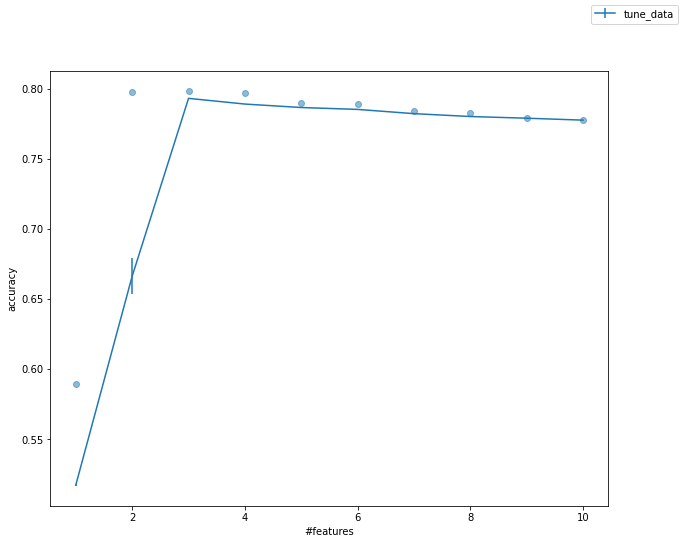

In [25]:
from sklearn.linear_model import LogisticRegression

# Specify features and labels
X = bacterialdata.drop(['species'], axis=1)
y = bacterialdata['species']

# Lists to store the feature combinations and their scores
scores_perNfeat = {'mean':[], 'max':[], 'var':[]}
best_feature_perNfeat = []

features = [] # start with empty set of features

# Define splitter object outside loop to ensure same splits over loop
splitter = KFold(n_splits=3, shuffle=True, random_state=None)

# For k in 1,...,p
for k in np.arange(1,X.shape[1]+1):
    best_score_k = 0
    scores_k_comb = []
    # Create and loop over all the possible features to add
    for feature_idx in np.arange(0,X.shape[1]):
        
        if feature_idx in features:
            continue
            
            
        temp_features = features + [feature_idx]
        # Select features from data
        X_c = X.iloc[:, temp_features]
        # Define model
        model = LogisticRegression()
        # Fit model and compute score on training data
        scores = cross_validate(model, X_c.values, y.values, cv=splitter, n_jobs=4)
        mean_cv_score = np.mean(scores['test_score'])
        # Save scores
        scores_k_comb.append(mean_cv_score)
        if mean_cv_score > best_score_k:
            best_feature = feature_idx
            best_score_k = mean_cv_score
    features.append(best_feature)
    # Save scores based on # features
    scores_perNfeat['max'].append(np.max(scores_k_comb))
    scores_perNfeat['var'].append(np.var(scores_k_comb))
    scores_perNfeat['mean'].append(np.mean(scores_k_comb))
    # Save best feature combination
    best_feature_perNfeat.append(features[:])

#Get variance of scores within grouped scores 
for i, score in enumerate(scores_perNfeat['max']):
    print("Best CV score using {} features: {}".format(i+1, score))

fig, ax = plt.subplots(1,1,figsize=(10,8), sharey=True)
ax.errorbar(np.arange(len(scores_perNfeat['mean']))+1, scores_perNfeat['mean'], scores_perNfeat['var'], label='tune_data')
ax.scatter(np.arange(len(scores_perNfeat['max']))+1, scores_perNfeat['max'], alpha=0.5)
ax.set_xlabel('#features')
ax.set_ylabel('accuracy')
fig.legend()
print('final set of features: {}'.format(set(best_feature_perNfeat[np.argmax(scores_perNfeat['max'])])))
best_feature_perNfeat

## Regularization methods: ridge regression and the lasso


Regularization is one of the most important concepts in machine learning to avoid overfitting. It comes in many forms. In linear regression, regularization techniques typically constrain the coefficient estimates. In return for a little extra bias, this reduces the variance of the coefficient esimates. The two main shrinkage techniques are **ridge regression** and the **lasso**. 

**Ridge regression penalizes the sum of the squares of the model weights by adding a term to the MSE loss function**:
![ridge](img/ridge.gif)


The lasso does a similar thing, but penalizes the absolute value of the model coefficients. The effect of both approaches is that the model coefficients are shrunk towards zero, resulting in less overfitting and less variance in the predictions (at the cost of a little more bias). We will apply both models on two datasets.

### Linear models for high dimensional data

We will apply ridge regression on the Communities and Crime Data Set. The dataset contains 123 population statistics on 1994 communities. We would like to predict the number of violent crimes per 100000 inhabitants. This is the final column of the dataframe. Of the 123 features, a lot contain missing values, so we will drop these columns and use only 99 features.

In [38]:
import pandas as pd
import numpy as np

data = pd.read_csv('./communities.csv')

# Drop columns with missing values
data = data.dropna(axis=1)
data.head()

,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,...,PctForeignBorn,PctBornSameState,PctSameHouse85,PctSameCity85,PctSameState85,LandArea,PopDens,PctUsePubTrans,LemasPctOfficDrugUn,ViolentCrimesPerPop
0,0.19,0.33,0.02,0.90,0.12,0.17,0.34,0.47,0.29,0.32,...,0.12,0.42,0.50,0.51,0.64,0.12,0.26,0.20,0.32,0.20
1,0.00,0.16,0.12,0.74,0.45,0.07,0.26,0.59,0.35,0.27,...,0.21,0.50,0.34,0.60,0.52,0.02,0.12,0.45,0.00,0.67
2,0.00,0.42,0.49,0.56,0.17,0.04,0.39,0.47,0.28,0.32,...,0.14,0.49,0.54,0.67,0.56,0.01,0.21,0.02,0.00,0.43
3,0.04,0.77,1.00,0.08,0.12,0.10,0.51,0.50,0.34,0.21,...,0.19,0.30,0.73,0.64,0.65,0.02,0.39,0.28,0.00,0.12
4,0.01,0.55,0.02,0.95,0.09,0.05,0.38,0.38,0.23,0.36,...,0.11,0.72,0.64,0.61,0.53,0.04,0.09,0.02,0.00,0.03


<div class="alert alert-success">
    <h2>Exercise</h2>
    <p>Use linear regression and ridge regression to predict the number of violent crimes per 100,000 inhabitants. Use 5-fold cross-validation to evaluate both models. The scikit-learn implementation of RidgeCV automatically performs cross-validation to tune the hyperparameter that determines the amount of regularization, so you don't need to implement a second cross-validation loop. Which model performs best?</p>
</div>

**Before we apply ridge regression, it's important to make sure that all the features are on the same scale. If one of the features is on a completely different scale (let's say, income can be measured in dollars or in thousands of dollars), this might lead the ridge regression coefficient to change substantially because of the penalty term in the optimization problem. We can make sure that all the features are on the same scale by dividing them by their respective standard deviation: (see book p. 232)**

\begin{equation}
\tilde{x}_{ij} = \frac{x_{ij} - \mu}{\sqrt{\frac{1}{n}\sum_{i=1}^{n}(x_{ij} - \bar{x}_{j})^2}}
\end{equation}

We can do this with the ```StandardScaler``` from scikit-learn. We will do the scaling each time in the cross-validation loop using only training data statistics. 

In [39]:
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

In [40]:
# Select X and y
y = data['ViolentCrimesPerPop'].values
X = data.drop(['ViolentCrimesPerPop'], axis=1).values

kf = KFold(n_splits=5)

linreg_scores = []
ridge_scores = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    
    scaler = StandardScaler()
    scaler.fit(X_train)
    
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    
    
    linregmodel = LinearRegression()
    ridgemodel = RidgeCV(alphas=np.logspace(-3,3,100))
    

    linregmodel.fit(X_train, y_train)
    linreg_scores.append(linregmodel.score(X_test,y_test))
    
    
    ridgemodel.fit(X_train, y_train)
    ridge_scores.append(ridgemodel.score(X_test,y_test))
    
    
    print('Regularization parameter: {}'.format(ridgemodel.alpha_))
    

print('Average validation fold R² of linear regression: {}'.format(np.mean(linreg_scores)))
print('Average validation fold R² of ridge regression: {}'.format(np.mean(ridge_scores)))

# ** solution

Regularization parameter: 26.560877829466893
Regularization parameter: 35.111917342151344
Regularization parameter: 40.37017258596558
Regularization parameter: 53.366992312063125
Regularization parameter: 26.560877829466893
Average validation fold R² of linear regression: 0.647667941596117
Average validation fold R² of ridge regression: 0.655688222206577


Now suppose that we don't have 99 features, but four times as many features. And suppose that a lot of features are correlated. This situation is very common in lots of datasets. We will mimic this situation by adding correlated features to our original feature matrix:

In [42]:
X_1 = X + np.random.normal(loc=0, scale=0.05, size=(X.shape))
X_2 = X + np.random.normal(loc=0, scale=0.1, size=(X.shape))
X_3 = X + np.random.normal(loc=0, scale=0.01, size=(X.shape))
X_expanded = np.concatenate((X, X_1, X_2, X_3), axis=1)

X_expanded.shape

(1994, 396)

<div class="alert alert-success">
    <h2>Exercise</h2>
    <p>Repeat the comparison between ridge regression and linear regression from above, but with the new feature matrix that contains correlated features. What happens with the performance of linear regression? What happens with the regularization parameter? Now, add even more correlated features and repeat the analysis.</p>
</div>

In [43]:
kf = KFold(n_splits=5)

linreg_scores = []
ridge_scores = []

for train_index, test_index in kf.split(X_expanded):
    X_train, X_test = X_expanded[train_index], X_expanded[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Scale X
    scaler = StandardScaler(with_mean=False)
    scaler.fit(X_train)
    
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    
    linregmodel = LinearRegression()
    ridgemodel = RidgeCV(alphas=np.logspace(-3,4,100))
    
    linregmodel.fit(X_train, y_train)
    linreg_scores.append(linregmodel.score(X_test,y_test))
    
    ridgemodel.fit(X_train, y_train)
    print('Regularization parameter: {}'.format(ridgemodel.alpha_))
    ridge_scores.append(ridgemodel.score(X_test,y_test))
    
    

print('Average validation fold R² of linear regression: {}'.format(np.mean(linreg_scores)))
print('Average validation fold R² of ridge regression: {}'.format(np.mean(ridge_scores)))
# ** solution

Regularization parameter: 628.0291441834247
Regularization parameter: 739.0722033525775
Regularization parameter: 1023.5310218990247
Regularization parameter: 869.7490026177834
Regularization parameter: 533.6699231206302
Average validation fold R² of linear regression: 0.5585691859208884
Average validation fold R² of ridge regression: 0.6486363793486598



Finally, it's interesting to look at how the amount of regularization in ridge regression and lasso regression affects the magnitudes of the fitted weights.

In [44]:
from sklearn.linear_model import Ridge, Lasso
from matplotlib import pyplot as plt
%matplotlib inline

y = data['ViolentCrimesPerPop'].values
X = data.drop(['ViolentCrimesPerPop'], axis=1).values
 
# Scale X
#scaler = StandardScaler(with_mean=False)
#x = scaler.fit_transform(X)
x = X
alphas = np.logspace(-5,2,100)

ridge_coefficients = np.ndarray(shape=(50, len(alphas)))
lasso_coefficients = np.ndarray(shape=(50, len(alphas)))

for i,a in enumerate(alphas):
    ridgemodel = Ridge(alpha=a)
    lassomodel = Lasso(alpha=a, max_iter=10000)
    
    ridgemodel.fit(X,y)
    lassomodel.fit(X,y)
    
    ridge_coefficients[:, i] = ridgemodel.coef_[:50]
    lasso_coefficients[:, i] = lassomodel.coef_[:50]

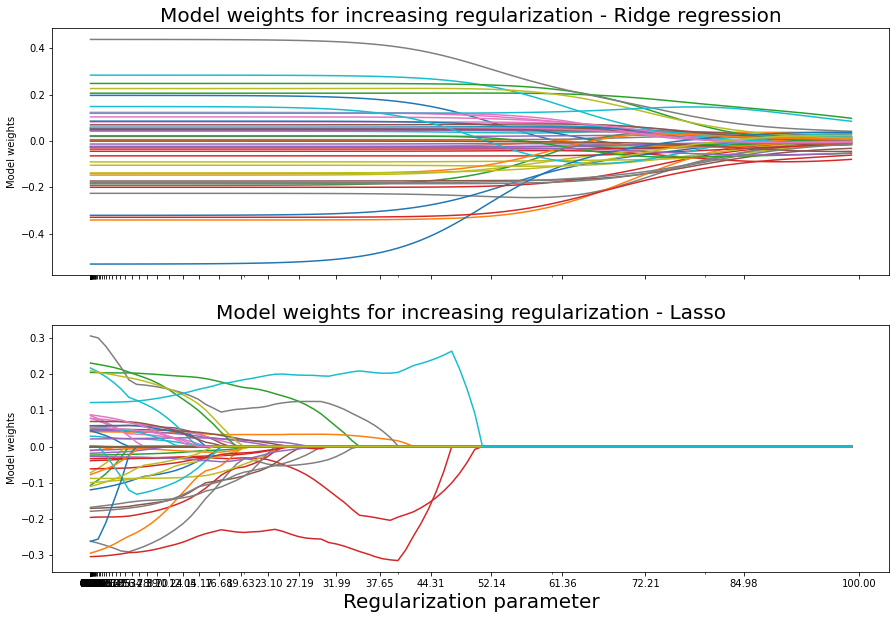

In [45]:
fig, ((ax1, ax2)) = plt.subplots(figsize=(15,10), nrows=2, sharex=True)

for c in range(ridge_coefficients.shape[0]):
    pd.Series(ridge_coefficients[c,:]).plot(ax=ax1)
    pd.Series(lasso_coefficients[c,:]).plot(ax=ax2)

ax2.set_xlabel('Regularization parameter').set_fontsize(20)
ax1.set_ylabel('Model weights')
ax2.set_ylabel('Model weights')
ax1.set_title('Model weights for increasing regularization - Ridge regression').set_fontsize(20)
ax2.set_title('Model weights for increasing regularization - Lasso').set_fontsize(20)
ax2.get_xaxis().set_ticks(alphas);

<div class="alert alert-success">
    <h2>Exercise</h2>
    <p>Make sure you understand the plots above. What is the main difference between ridge regression and the lasso?
    </p>
</div>

### Feature selection with the lasso

Suppose that we are interested in selecting only a couple of features out of a high dimensional dataset. Let's fit ridge regression and lasso regression on the data and look at the model coefficients for both models:

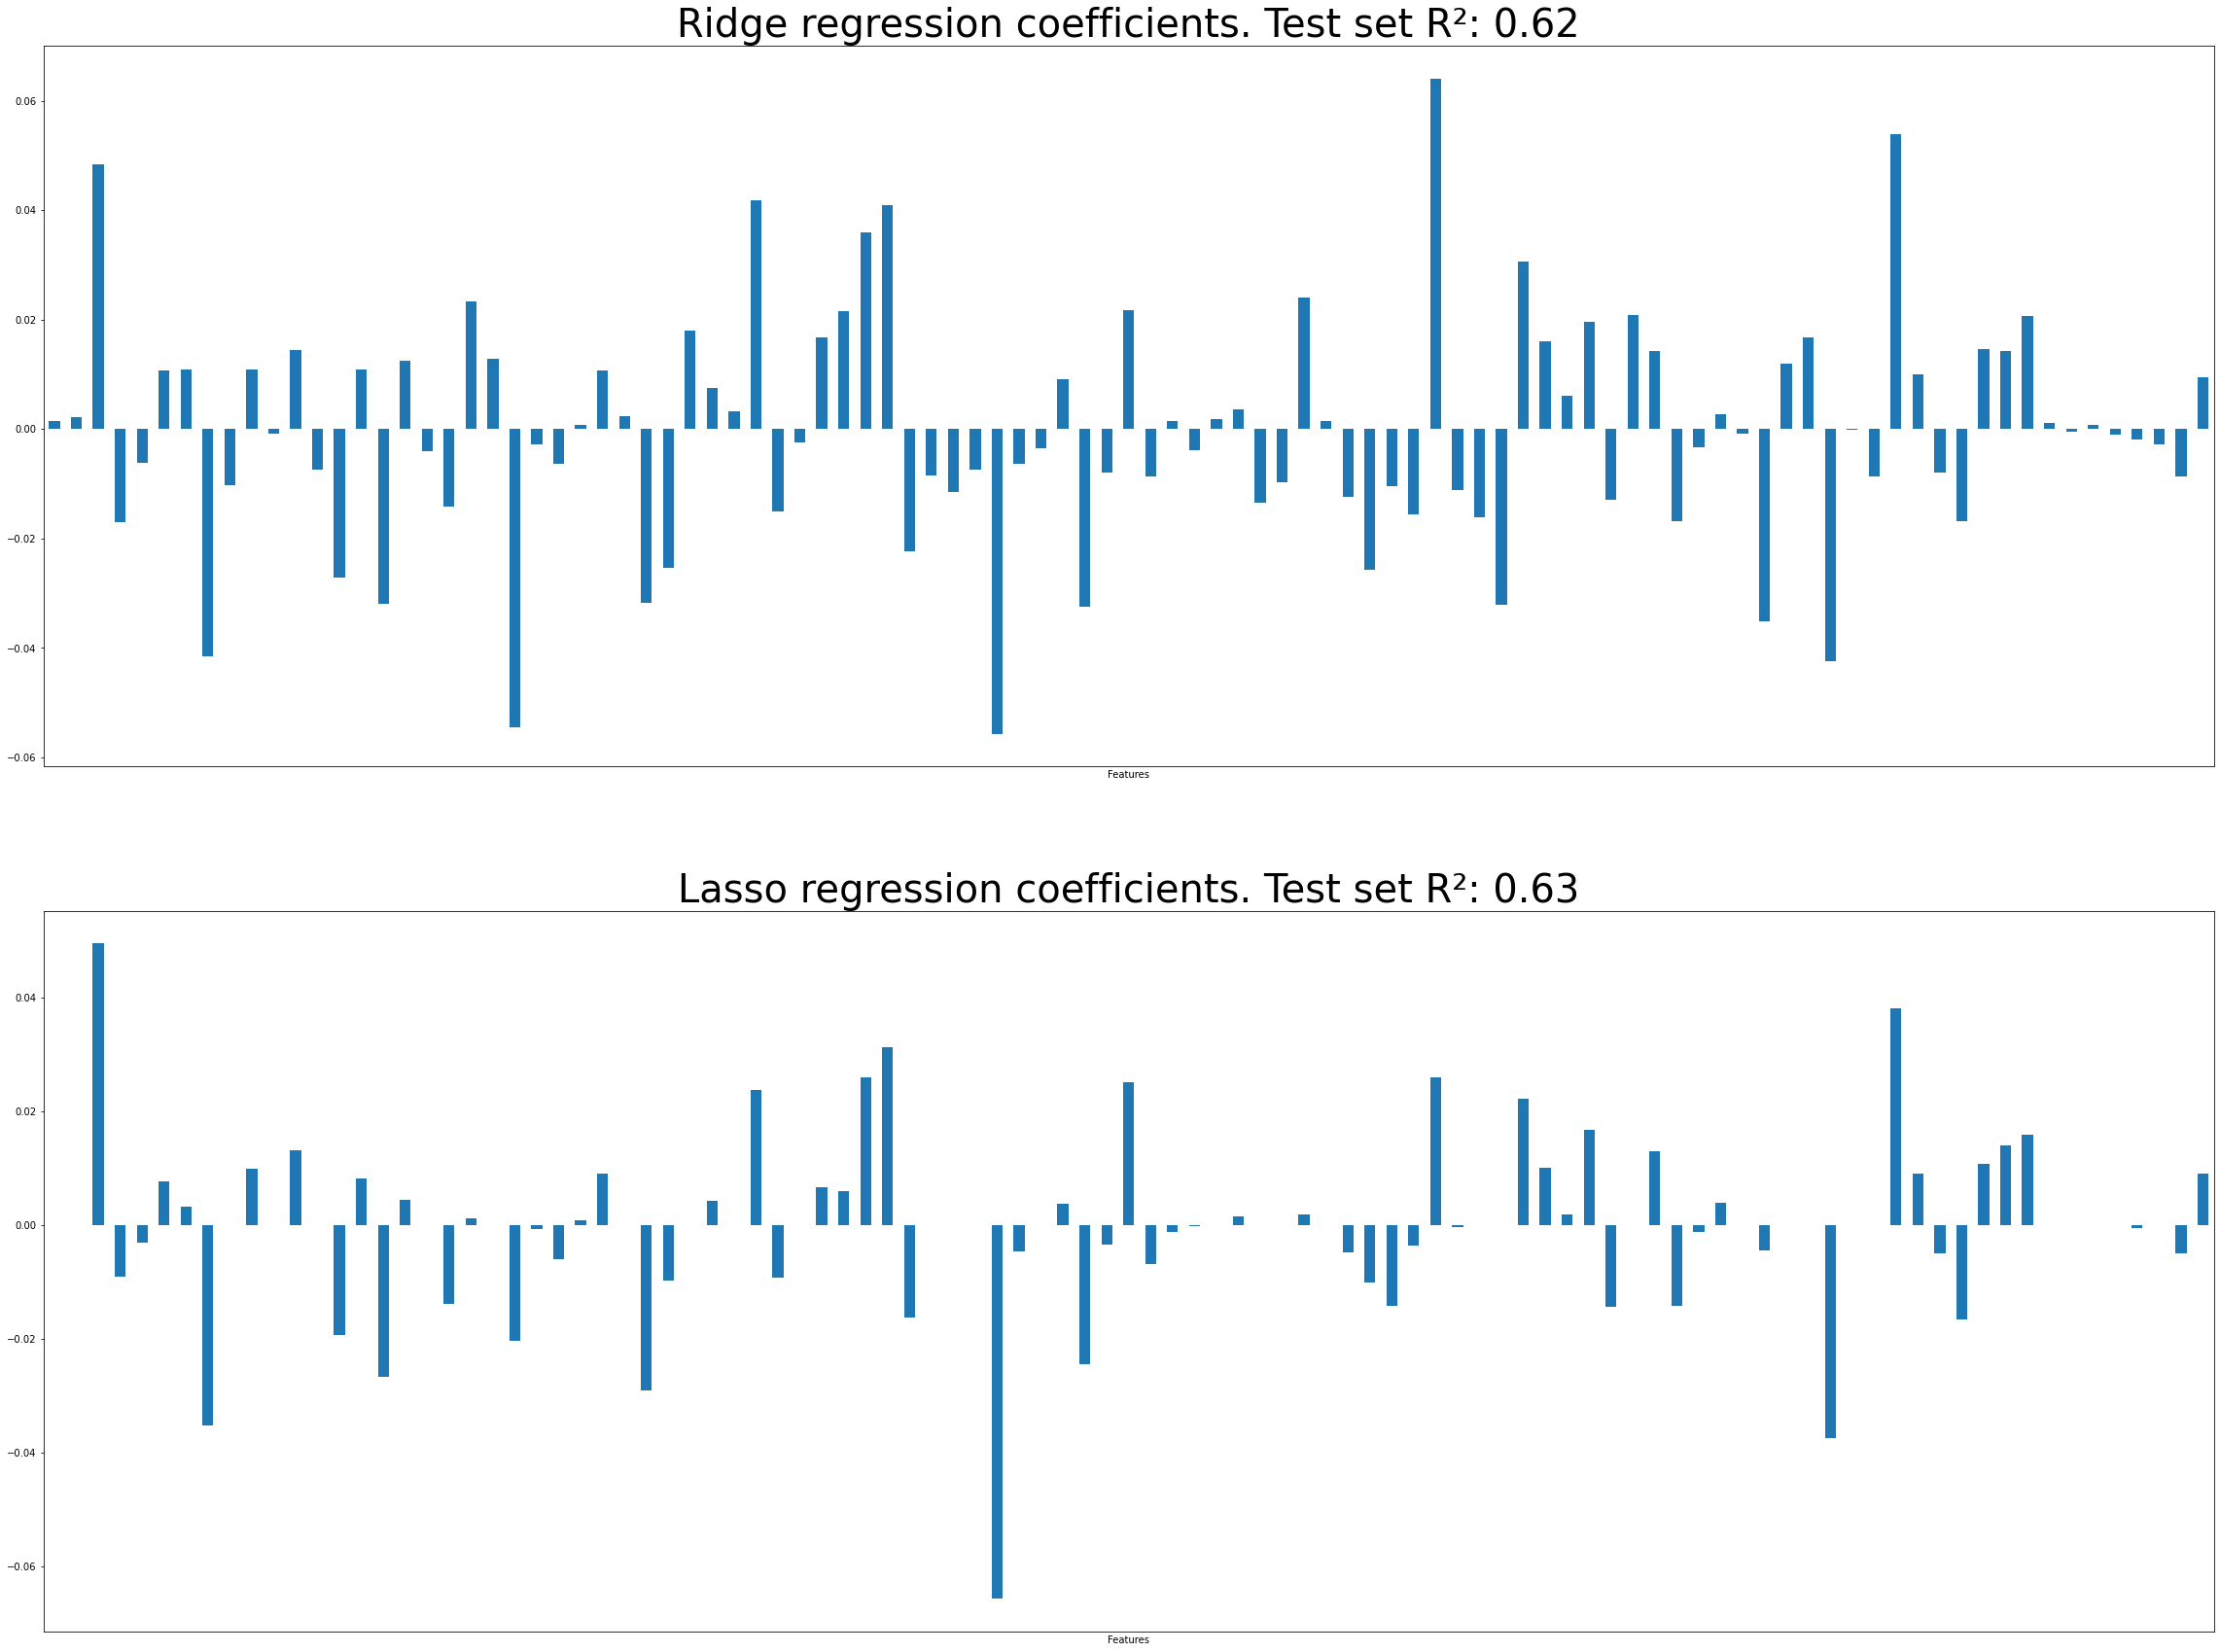

In [46]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split

ridgemodel = RidgeCV(cv=5)
lassomodel = LassoCV(cv=5, max_iter=10000)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Scale X
scaler = StandardScaler(with_mean=False)
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

ridgemodel.fit(X_train, y_train)
ridgescore = np.round(ridgemodel.score(X_test, y_test),2)
lassomodel.fit(X_train, y_train)
lassoscore = np.round(lassomodel.score(X_test, y_test),2)

# Plot of the coefficients for ridge regression
fig, ((ax1, ax2)) = plt.subplots(figsize=(40,30), nrows=2)
pd.Series(ridgemodel.coef_).plot(kind='bar', ax=ax1)
ax1.set_title('Ridge regression coefficients. Test set R²: {}'.format(ridgescore)).set_fontsize(40)
ax1.get_xaxis().set_ticks([])
ax1.set_xlabel('Features')

# Plot of the coefficients for the lasso
pd.Series(lassomodel.coef_).plot(kind='bar', ax=ax2)
ax2.set_title('Lasso regression coefficients. Test set R²: {}'.format(lassoscore)).set_fontsize(40)
ax2.get_xaxis().set_ticks([])
ax2.set_xlabel('Features');

The lasso applies regularization by constraining the sum of the absolute values of the model coefficients (the L1-norm). A result of this is that a lot of model coefficients are set to zero: the lasso performs **feature selection**. This is not the case for ridge regression: the model weights are rarely set to zero. Feature selection is a nice property if we want an interpretable model. Let's list the features with non-zero coefficients in the lasso: 

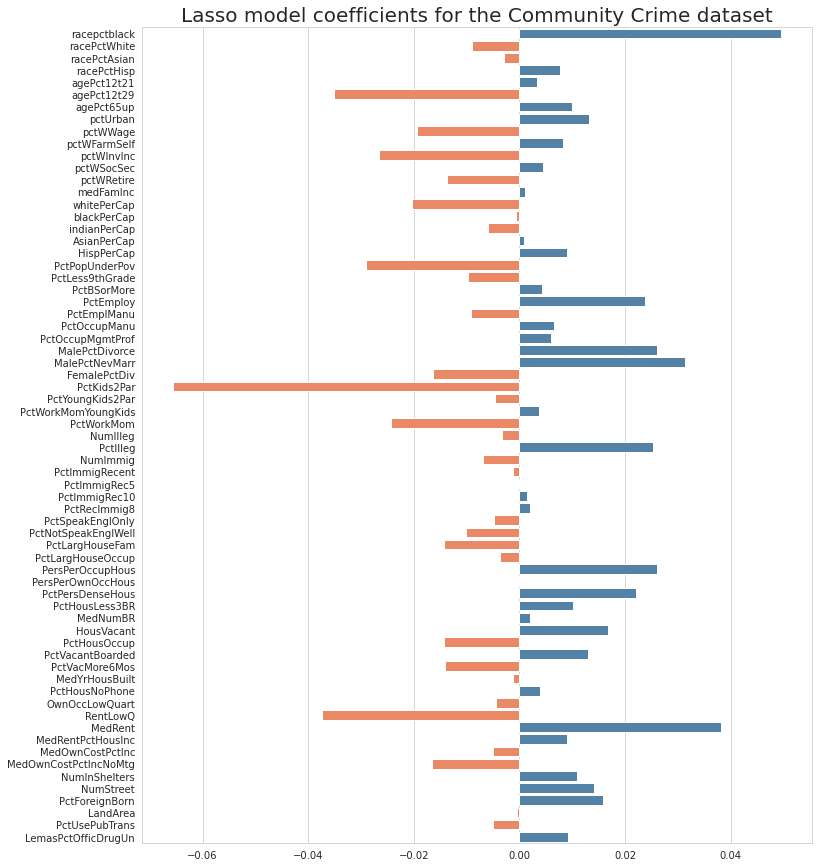

In [47]:
import seaborn as sns
sns.set_style('whitegrid')

fig, ax = plt.subplots(figsize=(12,15))
sns.barplot(x= pd.Series(lassomodel.coef_[lassomodel.coef_ != 0]),
            y=data.drop(['ViolentCrimesPerPop'], axis=1).columns[lassomodel.coef_ != 0],
            palette=['steelblue' if n > 0 else 'coral' for n in lassomodel.coef_[lassomodel.coef_ != 0]],
            ax=ax);
ax.set_title('Lasso model coefficients for the Community Crime dataset').set_fontsize(20);

### Regularization methods for $n < p$ data

In high dimensional data, we often have more features than observations. This is often called the $n < p$ scenario. In this situation, linear regression breaks down: the variance on the weight estimates blows up and the model will fail on unseen data. Both ridge regression and the lasso are valuable solutions here.

We will work with a dataset that contains spectral measurements on food samples. The target variables are the water, fat and protein content of the samples.

In [48]:
data.head()

,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,...,PctForeignBorn,PctBornSameState,PctSameHouse85,PctSameCity85,PctSameState85,LandArea,PopDens,PctUsePubTrans,LemasPctOfficDrugUn,ViolentCrimesPerPop
0,0.19,0.33,0.02,0.90,0.12,0.17,0.34,0.47,0.29,0.32,...,0.12,0.42,0.50,0.51,0.64,0.12,0.26,0.20,0.32,0.20
1,0.00,0.16,0.12,0.74,0.45,0.07,0.26,0.59,0.35,0.27,...,0.21,0.50,0.34,0.60,0.52,0.02,0.12,0.45,0.00,0.67
2,0.00,0.42,0.49,0.56,0.17,0.04,0.39,0.47,0.28,0.32,...,0.14,0.49,0.54,0.67,0.56,0.01,0.21,0.02,0.00,0.43
3,0.04,0.77,1.00,0.08,0.12,0.10,0.51,0.50,0.34,0.21,...,0.19,0.30,0.73,0.64,0.65,0.02,0.39,0.28,0.00,0.12
4,0.01,0.55,0.02,0.95,0.09,0.05,0.38,0.38,0.23,0.36,...,0.11,0.72,0.64,0.61,0.53,0.04,0.09,0.02,0.00,0.03


In [49]:
data = pd.read_csv('./meatNIR1000.csv',header=None)
colnames = pd.read_csv('./meatNIR1000.colnames', header=None)
data.columns = colnames.values[0]

data.head()

,852,852.396793587174,852.793587174349,853.190380761523,853.587174348697,853.983967935872,854.380761523046,854.77755511022,855.174348697395,855.571142284569,...,1047.61923847695,1048.01603206413,1048.4128256513,1048.80961923848,1049.20641282565,1049.60320641283,1050,water,fat,protein
0,2.61776,2.617830,2.617903,2.617978,2.618056,2.618137,2.618220,2.618307,2.618396,2.618488,...,2.843252,2.839238,2.835224,2.831212,2.827203,2.823199,2.81920,60.682046,22.567703,16.750251
1,2.83454,2.835379,2.836211,2.837037,2.837859,2.838677,2.839493,2.840308,2.841123,2.841941,...,3.199079,3.195870,3.192631,3.189364,3.186072,3.182757,3.17942,46.184739,40.261044,13.554217
2,2.58284,2.583193,2.583542,2.583886,2.584227,2.584566,2.584904,2.585241,2.585579,2.585919,...,2.567107,2.563911,2.560732,2.557568,2.554419,2.551283,2.54816,71.071071,8.408408,20.520521
3,2.82286,2.823218,2.823569,2.823913,2.824252,2.824587,2.824919,2.825252,2.825587,2.825926,...,2.820034,2.816008,2.812005,2.808026,2.804069,2.800134,2.79622,73.239437,5.935614,20.824950
4,2.78813,2.788479,2.788828,2.789177,2.789526,2.789876,2.790226,2.790577,2.790930,2.791284,...,3.161516,3.157539,3.153555,3.149563,3.145563,3.141552,3.13753,58.710977,25.679758,15.609265


In [50]:
# Read in the data
data = pd.read_csv('./meatNIR1000.csv',header=None)
colnames = pd.read_csv('./meatNIR1000.colnames', header=None)
data.columns = colnames.values[0]
W = data['water']
F = data['fat']
P = data['protein']

data = data.drop(['water', 'fat', 'protein'], axis=1)
data.head()

,852.000000,852.396794,852.793587,853.190381,853.587174,853.983968,854.380762,854.777555,855.174349,855.571142,...,1046.428858,1046.825651,1047.222445,1047.619238,1048.016032,1048.412826,1048.809619,1049.206413,1049.603206,1050.000000
0,2.61776,2.617830,2.617903,2.617978,2.618056,2.618137,2.618220,2.618307,2.618396,2.618488,...,2.855280,2.851276,2.847266,2.843252,2.839238,2.835224,2.831212,2.827203,2.823199,2.81920
1,2.83454,2.835379,2.836211,2.837037,2.837859,2.838677,2.839493,2.840308,2.841123,2.841941,...,3.208502,3.205398,3.202256,3.199079,3.195870,3.192631,3.189364,3.186072,3.182757,3.17942
2,2.58284,2.583193,2.583542,2.583886,2.584227,2.584566,2.584904,2.585241,2.585579,2.585919,...,2.576803,2.573551,2.570320,2.567107,2.563911,2.560732,2.557568,2.554419,2.551283,2.54816
3,2.82286,2.823218,2.823569,2.823913,2.824252,2.824587,2.824919,2.825252,2.825587,2.825926,...,2.832259,2.828159,2.824084,2.820034,2.816008,2.812005,2.808026,2.804069,2.800134,2.79622
4,2.78813,2.788479,2.788828,2.789177,2.789526,2.789876,2.790226,2.790577,2.790930,2.791284,...,3.173418,3.169454,3.165488,3.161516,3.157539,3.153555,3.149563,3.145563,3.141552,3.13753


We have 240 observations, but 500 features, so we are in a $n < p$ setting:

In [51]:
data.shape

(240, 500)

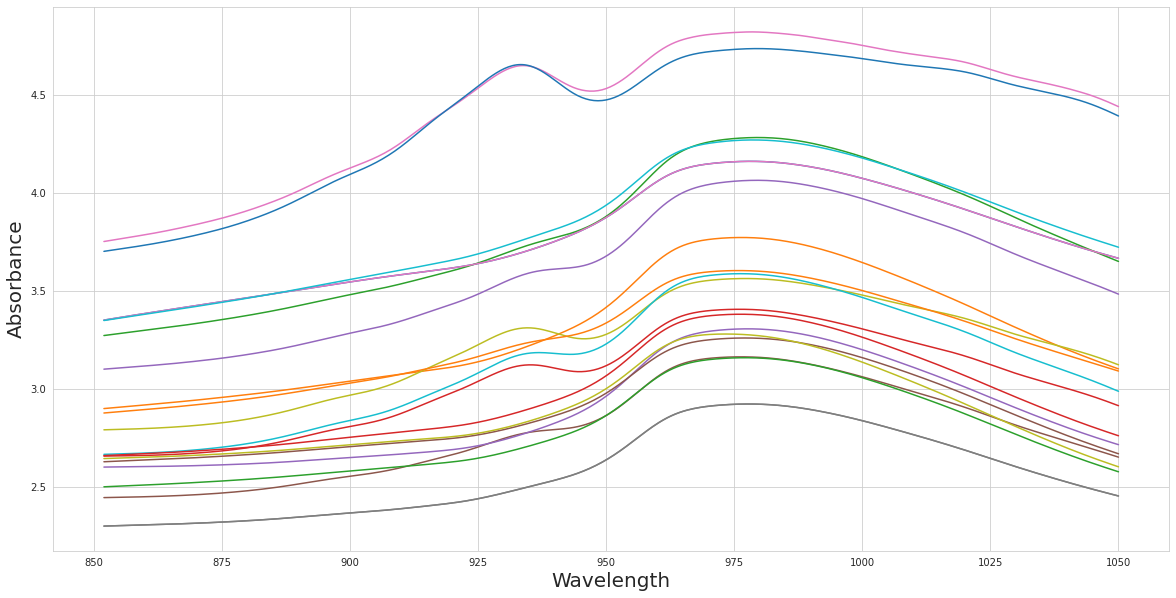

In [52]:
# let's plot some random data points

fig, ax = plt.subplots(figsize=(20,10))
for i in range(20):
    ax.plot(data.iloc[np.random.choice(range(len(data)))])
ax.set_xlabel('Wavelength').set_fontsize(20)
ax.set_ylabel('Absorbance').set_fontsize(20)

<div class="alert alert-success">
    <h2>Exercise</h2>
    <p>Try to fit a linear regression model to predict the fat content of a sample on the entire dataset. Look at the model coefficients. What happens?
    </p>
</div>

In [53]:
from sklearn.linear_model import LinearRegression
X = data.values
model = LinearRegression()

model.fit(X, F)

model.coef_[:20]

array([-2.96403020e+12,  1.72417784e+13, -1.76200072e+13, -2.86291092e+12,
        5.34766451e+12, -2.82662862e+12, -1.64939925e+13,  2.36513882e+13,
        9.09016438e+12,  3.28787718e+12, -7.74371603e+12, -1.13452889e+13,
       -2.60004072e+12, -1.58062527e+13,  3.56877808e+13, -8.68429013e+12,
       -8.01041335e+12, -1.37570669e+13,  2.08193122e+13,  9.94180732e+11])

<div class="alert alert-success">
    <h2>Exercise</h2>
    <p>Compare the performance of linear regression with ridge regression or with the lasso. Use 5-fold cross-validation to evaluate both models.
    </p>
</div>

In [55]:
import warnings
warnings.filterwarnings('ignore')

#** solution
from sklearn.linear_model import LassoCV, RidgeCV
# Select X and y
y = F
X = data.values

kf = KFold(n_splits=5)

linreg_scores = []
ridge_scores = []
lasso_scores = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
        
    scaler = StandardScaler(with_std=False)
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    
    linregmodel = LinearRegression()
    ridgemodel = RidgeCV(alphas=np.logspace(-1,4,10))
    lassomodel = LassoCV(alphas=np.logspace(-1,4,10))
    
    linregmodel.fit(X_train, y_train)
    linreg_scores.append(linregmodel.score(X_test,y_test))
    
    ridgemodel.fit(X_train, y_train)
    ridge_scores.append(ridgemodel.score(X_test,y_test))
    
    lassomodel.fit(X_train, y_train)
    lasso_scores.append(lassomodel.score(X_test,y_test))


    

print('Average validation fold R² of linear regression: {}'.format(np.mean(linreg_scores)))
print('Average validation fold R² of ridge regression: {}'.format(np.mean(ridge_scores)))
print('Average validation fold R² of lasso regression: {}'.format(np.mean(lasso_scores)))
#**solution

Average validation fold R² of linear regression: -0.4426431256304994
Average validation fold R² of ridge regression: 0.8733747864891714
Average validation fold R² of lasso regression: 0.6884602439986897
